Processing variables (Spatial Unrolling)...
Merging and creating DataFrame...
Final Data Shape: (351424, 14)
Original Year Range: 1950 - 2025
Filtered Year Range: 1950 - 2021
Final Data Shape: (332928, 14)
Training HistGradientBoostingClassifier (Aggressive Tuning)...

--- Calculating Metrics ---
Running Cross-Validation (5-fold)...
Accuracy on training set: 0.883402
Accuracy on test set:     0.842865
Average Accuracy (CV):    0.7157
95% Confidence Interval:  0.7157 ± 0.1044
                          (0.6113 - 0.8202)

Classification Report:
              precision    recall  f1-score   support

    Pre-1990       0.84      0.89      0.86     36992
   Post-1990       0.85      0.79      0.82     29594

    accuracy                           0.84     66586
   macro avg       0.84      0.84      0.84     66586
weighted avg       0.84      0.84      0.84     66586



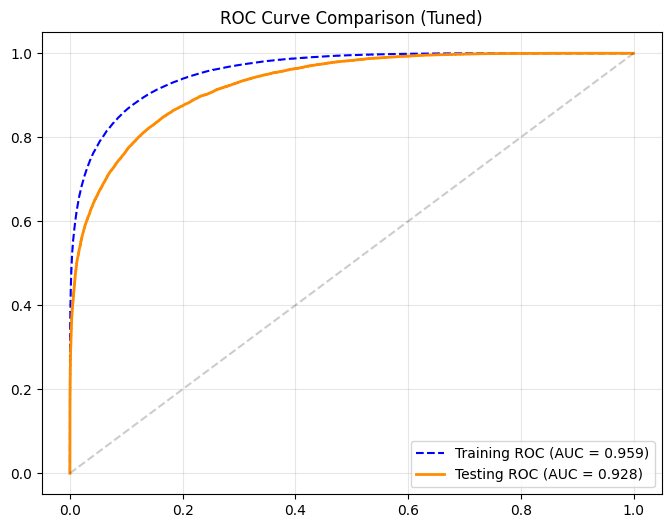

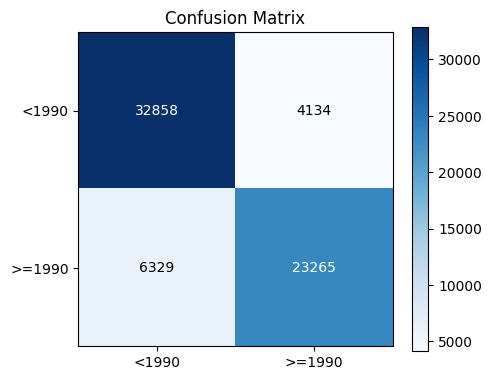

Generating Classifier Output Histogram...


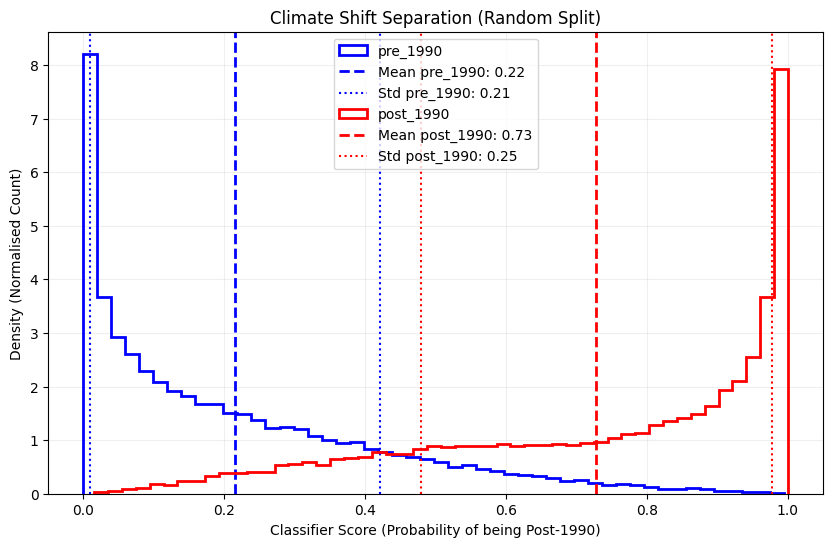

Calculating feature importance...


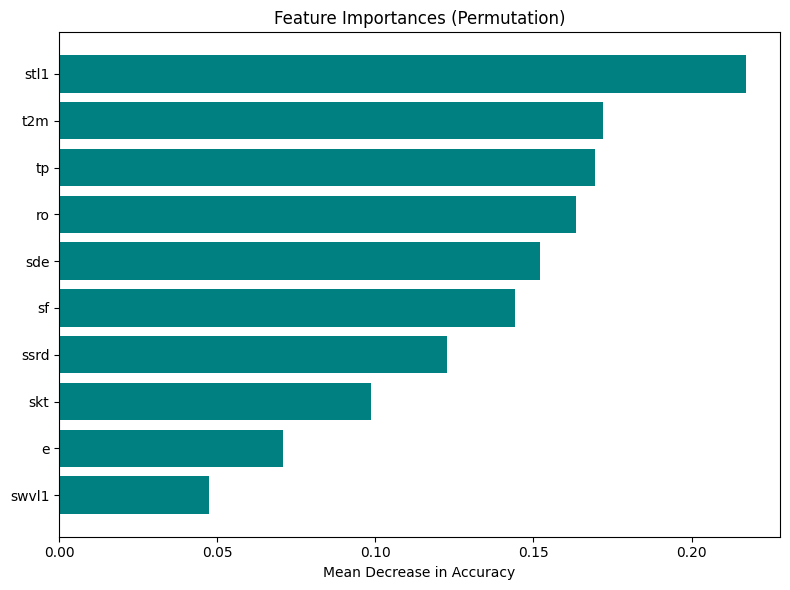

In [1]:
# Full Master Pipeline: TUNED for Better Separation
# - Increased model complexity (max_iter=1000, max_depth=15) to push separation
# - Includes all metrics and custom plots

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import (roc_curve, auc, confusion_matrix, classification_report)
from scipy.stats import sem, t
import joblib
import os

# ---------------------------
# 1. User settings / file paths
# ---------------------------
file_path = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/11variables.nc'
out_folder = '/Users/ghosh/OneDrive/Documents/Year 4/Final project/ml_outputs_tuned'
os.makedirs(out_folder, exist_ok=True)

model_outfile = os.path.join(out_folder, 'gbdt_tuned_model.joblib')
pred_csv = os.path.join(out_folder, 'gbdt_test_predictions.csv')

# ---------------------------
# 2. Data Loading & Processing
# ---------------------------
vars_10 = ['t2m', 'skt', 'stl1', 'swvl1', 'sde', 'tp', 'e', 'ro', 'sf', 'ssrd']
ds = xr.open_dataset(file_path)
missing = [v for v in vars_10 if v not in ds.data_vars]
if missing: raise RuntimeError(f"Missing: {missing}")

# UK Subset
N, S, E, W = 61, 49, 2, -10
uk = ds.sel(latitude=slice(N, S), longitude=slice(W, E))
time_coord = 'valid_time' if 'valid_time' in uk.coords else list(uk.coords)[0]

# Monthly -> Yearly Logic
days = uk[time_coord].dt.days_in_month
days_3d = days.broadcast_like(uk['t2m'])
yearly_das = []
seconds_per_year = 365.25 * 24 * 3600.0

print("Processing variables (Spatial Unrolling)...")
for v in vars_10:
    da = uk[v]
    if v in ['tp', 'e', 'ro', 'sf']: # Accumulation
        yearly_da = (da * days_3d).groupby(uk[time_coord].dt.year).sum(dim=time_coord) * 1000.0
    elif v == 'ssrd': # Energy
        yearly_da = da.groupby(uk[time_coord].dt.year).sum(dim=time_coord) / seconds_per_year
    else: # State
        yearly_da = da.groupby(uk[time_coord].dt.year).mean(dim=time_coord)
        if v in ['t2m', 'skt', 'stl1']: yearly_da -= 273.15
    yearly_da.name = v
    yearly_das.append(yearly_da)

print("Merging and creating DataFrame...")
df = xr.merge(yearly_das).to_dataframe().reset_index()
df = df.dropna(how='any').reset_index(drop=True)
print(f"Final Data Shape: {df.shape}")

# --- FILTER: Remove 2022 and later ---
print(f"Original Year Range: {df['year'].min()} - {df['year'].max()}")
df = df[df['year'] < 2022]
print(f"Filtered Year Range: {df['year'].min()} - {df['year'].max()}")
# -------------------------------------
print(f"Final Data Shape: {df.shape}")

# ---------------------------
# 3. Features & Target
# ---------------------------
df['target'] = (df['year'] >= 1990).astype(int)
feature_cols = [c for c in df.columns if c not in ['year', 'target', 'latitude', 'longitude', 'number']]
X = df[feature_cols].values
y = df['target'].values

# Train/Test Split
X_train, X_test, y_train, y_test, years_train, years_test = train_test_split(
    X, y, df['year'].values, test_size=0.2, random_state=42, stratify=y
)

# ---------------------------
# 4. Train Model (TUNED SETTINGS)
# ---------------------------
print("Training HistGradientBoostingClassifier (Aggressive Tuning)...")
clf = HistGradientBoostingClassifier(
    max_iter=1000,       # More trees (was 100) -> pushes confidence
    max_depth=15,        # Deeper trees -> learns finer details
    learning_rate=0.15,  # Faster learning
    min_samples_leaf=40, # Prevents overfitting on noise
    random_state=42
)
clf.fit(X_train, y_train)

# ---------------------------
# 5. Advanced Metrics
# ---------------------------
print("\n--- Calculating Metrics ---")
acc_train = clf.score(X_train, y_train)
acc_test = clf.score(X_test, y_test)

# Cross Validation (CV)
print("Running Cross-Validation (5-fold)...")
cv_scores = cross_val_score(clf, X, y, cv=5, n_jobs=-1) 
mean_cv = cv_scores.mean()
std_cv = cv_scores.std()

mean_score = cv_scores.mean()
standard_error = sem(cv_scores)
confidence = 0.95
h = standard_error * t.ppf((1 + confidence) / 2, len(cv_scores) - 1)

print(f"Accuracy on training set: {acc_train:.6f}")
print(f"Accuracy on test set:     {acc_test:.6f}")
print(f"Average Accuracy (CV):    {mean_cv:.4f}")
print(f"95% Confidence Interval:  {mean_score:.4f} ± {h:.4f}")
print(f"                          ({mean_score - h:.4f} - {mean_score + h:.4f})")

y_pred = clf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Pre-1990', 'Post-1990']))

# ---------------------------
# 6. Plot: Dual ROC
# ---------------------------
y_prob_test = clf.predict_proba(X_test)[:, 1]
y_prob_train = clf.predict_proba(X_train)[:, 1]

fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
auc_test = auc(fpr_test, tpr_test)
auc_train = auc(fpr_train, tpr_train)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Training ROC (AUC = {auc_train:.3f})', linestyle='--', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Testing ROC (AUC = {auc_test:.3f})', linewidth=2, color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.2)
plt.title('ROC Curve Comparison (Tuned)')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(os.path.join(out_folder, 'roc_comparison_tuned.png'), dpi=150)
plt.show()

# ---------------------------
# 7. Plot: Confusion Matrix
# ---------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xticks([0, 1], ['<1990', '>=1990'])
plt.yticks([0, 1], ['<1990', '>=1990'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black' if cm[i,j] < cm.max()/2 else 'white')
plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'confusion_matrix.png'), dpi=150)
plt.show()


# ---------------------------
# 8. Plot: Classifier Output Histogram (Random Split)
# ---------------------------
print("Generating Classifier Output Histogram...")

# Separate the probabilities for the two classes
probs_pre = y_prob_test[y_test == 0]
probs_post = y_prob_test[y_test == 1]

# Calculate Statistics
mu_pre = np.mean(probs_pre)
std_pre = np.std(probs_pre)
mu_post = np.mean(probs_post)
std_post = np.std(probs_post)

plt.figure(figsize=(10, 6))

# --- Plot Pre-1990 (Blue) ---
# 1. The Histogram
plt.hist(probs_pre, bins=50, histtype='step', color='blue', linewidth=2, density=True, label='pre_1990')
# 2. The Mean Line
plt.axvline(mu_pre, color='blue', linestyle='--', linewidth=2, label=f'Mean pre_1990: {mu_pre:.2f}')
# 3. The Std Dev Lines
plt.axvline(mu_pre - std_pre, color='blue', linestyle=':', linewidth=1.5, label=f'Std pre_1990: {std_pre:.2f}')
plt.axvline(mu_pre + std_pre, color='blue', linestyle=':', linewidth=1.5)

# --- Plot Post-1990 (Red) ---
# 1. The Histogram
plt.hist(probs_post, bins=50, histtype='step', color='red', linewidth=2, density=True, label='post_1990')
# 2. The Mean Line
plt.axvline(mu_post, color='red', linestyle='--', linewidth=2, label=f'Mean post_1990: {mu_post:.2f}')
# 3. The Std Dev Lines
plt.axvline(mu_post - std_post, color='red', linestyle=':', linewidth=1.5, label=f'Std post_1990: {std_post:.2f}')
plt.axvline(mu_post + std_post, color='red', linestyle=':', linewidth=1.5)

# --- Final Formatting ---
plt.xlabel('Classifier Score (Probability of being Post-1990)')
plt.ylabel('Density (Normalised Count)')
plt.title('Climate Shift Separation (Random Split)')
plt.legend(loc='best')
plt.grid(alpha=0.2)
#plt.savefig(os.path.join(out_folder, 'classifier_output_random_stats.png'), dpi=150)
plt.show()


# ---------------------------
# 9. Plot: Feature Importances
# ---------------------------
print("Calculating feature importance...")
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importances = result.importances_mean
feat_order = np.argsort(importances)[::-1]
labels = np.array(feature_cols)[feat_order]

plt.figure(figsize=(8, 6))
plt.barh(labels, importances[feat_order], color='teal')
plt.gca().invert_yaxis()
plt.title('Feature Importances (Permutation)')
plt.xlabel('Mean Decrease in Accuracy')
plt.tight_layout()
plt.show()